In [11]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import os

## Load data from sql loss_profit.db

In [12]:
# Load database .db from pipelines/data_engineer/database/loss_profit.db
from sqlalchemy import create_engine, text
from pathlib import Path

CURR_DIR = Path.cwd()
ROOT_DIR = CURR_DIR.parent.parent
DB_PATH = ROOT_DIR / 'data_engineer' / 'database' / 'loss_profit.db'

# Load data base .db and check tables
engine = create_engine(f'sqlite:///{DB_PATH}')
with engine.connect() as connection:
    result = connection.execute(text("SELECT name FROM sqlite_master WHERE type='table';"))
    tables = result.fetchall()
    print("Tables in the database:")
    for table in tables:
        print(table[0])

if tables:
    for table_name in tables:
        with engine.connect() as connection:
            query = text(f"SELECT * FROM {table_name[0]}")
            df = pd.read_sql(query, connection)
            print(f"\nData from table '{table_name[0]}':")
            print(f"Database: {df.head()}")
else:
    print("No tables found in the database.")

Tables in the database:
loss_profit

Data from table 'loss_profit':
Database:      item_id  purchase_count  price  stocks   sales  stock_value profit_status
0  item_0001              34   88.0      98  2992.0       8624.0        profit
1  item_0002              37  116.0      55  4292.0       6380.0        profit
2  item_0003              49  103.0      46  5047.0       4738.0        profit
3  item_0004              21   59.0      86  1239.0       5074.0        profit
4  item_0005              49   97.0      76  4753.0       7372.0        profit


## Database as df -> Transformed database by data_engineer dir

### - **Added new column on total_revenue, stock_value, profit_status**

In [13]:
df

,item_id,purchase_count,price,stocks,sales,stock_value,profit_status
0,item_0001,34,88.0,98,2992.0,8624.0,profit
1,item_0002,37,116.0,55,4292.0,6380.0,profit
2,item_0003,49,103.0,46,5047.0,4738.0,profit
3,item_0004,21,59.0,86,1239.0,5074.0,profit
4,item_0005,49,97.0,76,4753.0,7372.0,profit
...,...,...,...,...,...,...,...
8620,item_8621,14,23.0,41,322.0,943.0,profit
8621,item_8622,4,119.0,18,476.0,2142.0,profit
8622,item_8623,42,36.0,75,1512.0,2700.0,profit
8623,item_8624,31,34.0,90,1054.0,3060.0,profit


In [14]:
df.describe()

,purchase_count,price,stocks,sales,stock_value
count,8625.000000,8625.000000,8625.000000,8625.000000,8625.000000
mean,25.155246,83.105739,54.746783,2085.258435,4552.094493
std,14.748412,39.679490,26.085713,1686.954926,3235.795436
min,0.000000,15.000000,10.000000,0.000000,160.000000
25%,12.000000,49.000000,32.000000,710.000000,1885.000000
50%,25.000000,83.000000,54.000000,1643.000000,3741.000000
75%,38.000000,118.000000,77.000000,3108.000000,6533.000000
max,50.000000,150.000000,100.000000,7500.000000,14751.000000


# 🎯 Purporse project

### 1. Modeling with **Tensorflow** LSTM for predicting sales, stocks needed, valuable ecommerce

### 2. Finetuning LLM for getting reason business impact

### 3. FAISS embedding documents to analyze by PDF documents as reliable & reasonable

### 4. RAG for provide the LLM with the most up-to-date data from your database

In [15]:
print(ROOT_DIR)

/Users/miftahhadiyannoor/Documents/Fashion_Recommendation_Engineer/pipelines


## Load PDF Documents

In [16]:
# Load documents for FAISS vector store
loader = PyPDFLoader(str(ROOT_DIR / 'ai_engineer' / 'FAISS' / 'Docs' / 'PDF_ecommerce_revenue.pdf'))
documents = loader.load()

print(f"Loaded {len(documents)} documents.")
print(f"First document content:\n{documents[0].page_content[:1000]}...")
print(f"Metadata of the first document:\n{documents[0].metadata}")

Loaded 9 documents.
First document content:
Received 4 February 2025, accepted 11 April 2025, date of publication 22 April 2025, date of current version 2 May 2025.
Digital Object Identifier 10.1 109/ACCESS.2025.3563371
Dynamic Pricing Models in E-Commerce:
Exploring Machine Learning Techniques to
Balance Profitability and Customer Satisfaction
XIAOCHEN GUO
 1 AND LEI ZHANG 2,3
1Management School, Anhui Business and Technology College, Hefei 230041, China
2School of Information Engineering, Anhui Business and Technology College, Hefei 230041, China
3College of Computing, Informatics and Mathematics, Universiti Teknologi MARA, Shah Alam, Selangor 40450, Malaysia
Corresponding author: Xiaochen Guo (ahahbvcgxc@163.com)
This work was supported in part by the 2024 Anhui Provincial Humanities and Social Sciences Research Project (Major), Project Name:
Research on Risk Perception, Response Behavior and Mechanism of Smart Connected V ehicle Consumers under the Background of Data
Security under

##  Explore Raw Document Stats

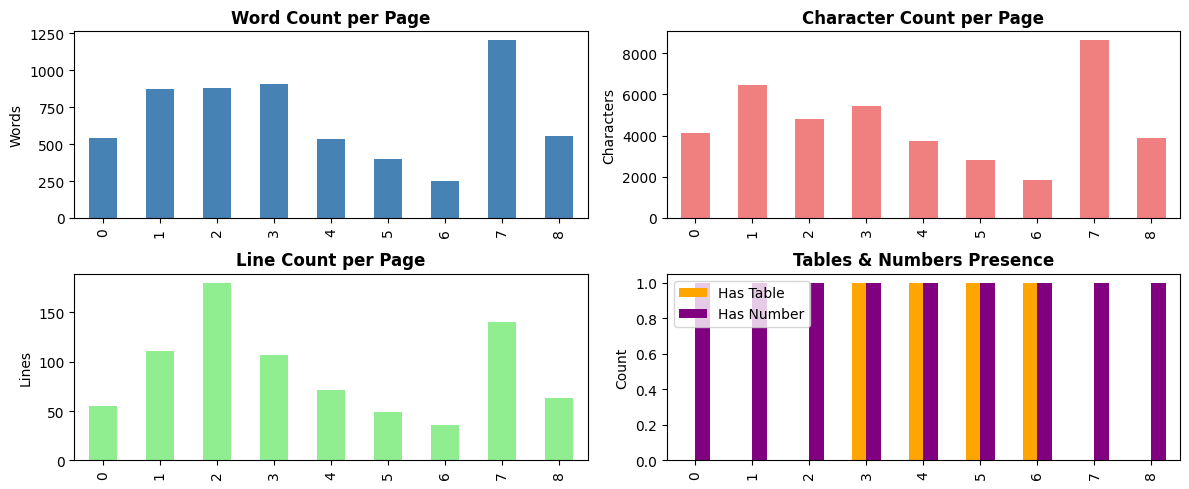

Document Statistics Summary:


,page,char_count,word_count,line_count,has_table,has_number
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,4.000000,4634.777778,682.000000,90.222222,0.444444,1.0
std,2.738613,2026.309439,299.774916,47.751382,0.527046,0.0
min,0.000000,1818.000000,253.000000,36.000000,0.000000,1.0
25%,2.000000,3740.000000,534.000000,55.000000,0.000000,1.0
50%,4.000000,4133.000000,554.000000,71.000000,0.000000,1.0
75%,6.000000,5425.000000,877.000000,111.000000,1.000000,1.0
max,8.000000,8635.000000,1204.000000,180.000000,1.000000,1.0


In [17]:
import matplotlib.pyplot as plt

page_records = []
for i, p in enumerate(documents):
    text = p.page_content
    page_records.append({
        'page': p.metadata.get('page', i),
        'char_count': len(text),
        'word_count': len(text.split()),
        'line_count': text.count('\n'),
        'has_table': int('Table' in text or 'table' in text),  # Convert to numeric
        'has_number': int(any(char.isdigit() for char in text))  # Convert to numeric
    })

df_pages = pd.DataFrame(page_records)

# Create proper 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Plot 1: Word Count per Page
df_pages['word_count'].plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Word Count per Page', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Words')

# Plot 2: Character Count per Page
df_pages['char_count'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Character Count per Page', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Characters')

# Plot 3: Line Count per Page
df_pages['line_count'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Line Count per Page', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Lines')

# Plot 4: Tables & Numbers Presence (converted to numeric)
df_pages[['has_table', 'has_number']].plot(kind='bar', ax=axes[1, 1], color=['orange', 'purple'])
axes[1, 1].set_title('Tables & Numbers Presence', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['Has Table', 'Has Number'])

plt.tight_layout()
plt.show()

print("Document Statistics Summary:")
display(df_pages.describe())

## Text Splitting & Chunk Analysis

In [18]:
# Text splitting & Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents=documents)

print(f"Total chunks created: {len(chunks)}")
print(f"First chunk content:\n{chunks[0].page_content[:1000]})...")
print(f"Metadata of the first chunk:\n{chunks[0].metadata}")
print(f"Avg characters per chunk: {sum(len(c.page_content) for c in chunks) / len(chunks):.2f}")

Total chunks created: 55
First chunk content:
Received 4 February 2025, accepted 11 April 2025, date of publication 22 April 2025, date of current version 2 May 2025.
Digital Object Identifier 10.1 109/ACCESS.2025.3563371
Dynamic Pricing Models in E-Commerce:
Exploring Machine Learning Techniques to
Balance Profitability and Customer Satisfaction
XIAOCHEN GUO
 1 AND LEI ZHANG 2,3
1Management School, Anhui Business and Technology College, Hefei 230041, China
2School of Information Engineering, Anhui Business and Technology College, Hefei 230041, China
3College of Computing, Informatics and Mathematics, Universiti Teknologi MARA, Shah Alam, Selangor 40450, Malaysia
Corresponding author: Xiaochen Guo (ahahbvcgxc@163.com)
This work was supported in part by the 2024 Anhui Provincial Humanities and Social Sciences Research Project (Major), Project Name:
Research on Risk Perception, Response Behavior and Mechanism of Smart Connected V ehicle Consumers under the Background of Data)...
Metadata

## Business Keyword Frequency

revenue: 8
profit: 19
loss: 7
sales: 1
cost: 1
growth: 1
decline: 0
stock: 0
market: 20
customer: 80
demand: 19
supply: 4
investment: 1
order: 0
trend: 0
discount: 0
return: 0
models: 46
model: 49
forecasting: 5
analysis: 14


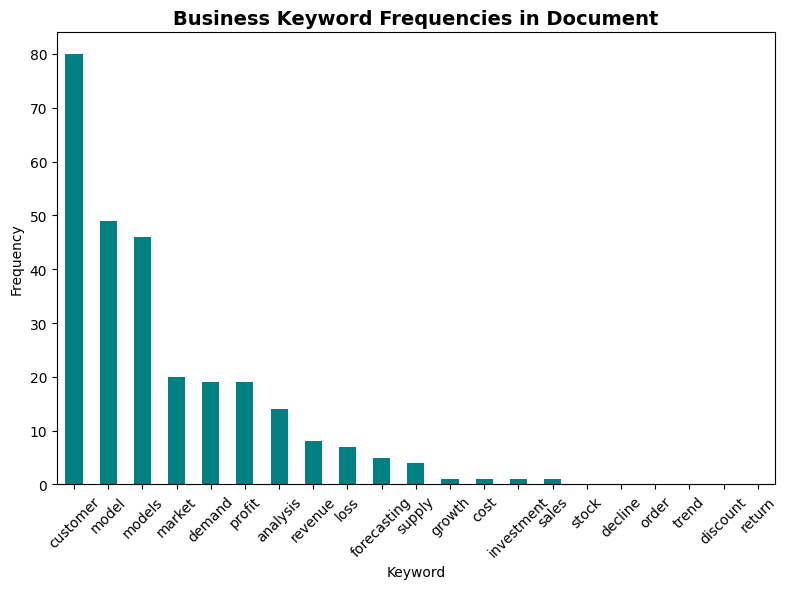

In [28]:
# Finding business keywords in the document

from collections import Counter
import re

KEYWORDS = ['revenue', 'profit', 'loss', 'sales', 'cost', 'growth', 'decline', 'stock',
            'market', 'customer', 'demand', 'supply', 'investment', 'order', 'trend', 'discount'
            , 'return', 'models', 'model', 'forecasting', 'analysis']

full_text = ' '.join([p.page_content for p in documents]).lower()
keyword_counts = Counter()
keyword_series = pd.Series({keyword: len(re.findall(r'\b' + re.escape(keyword) + r'\b', full_text)) for keyword in KEYWORDS})
for keyword, count in keyword_series.items():
    print(f"{keyword}: {count}")

# Plotting keyword frequencies
plt.figure(figsize=(8, 6))
keyword_series.sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title('Business Keyword Frequencies in Document', fontsize=14, fontweight='bold')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Embeddings & Semantic Space (PCA)

In [ ]:
import numpy as np

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

sample_chunks = chunks[:5]
for i, chunk in enumerate(sample_chunks):
    embedding_vector = embeddings.embed_documents([chunk.page_content])
    print(f"Chunk {i+1} embedding vector (first 5 values): {embedding_vector[0][:5]}")

Chunk 1 embedding vector (first 5 values): [-0.027460481971502304, 0.022519459947943687, 0.0035044688265770674, 0.06817476451396942, -7.569941953988746e-05]
Chunk 2 embedding vector (first 5 values): [0.008168643340468407, 0.0503382682800293, 0.012880058959126472, -0.0021120028104633093, 0.012029556557536125]
Chunk 3 embedding vector (first 5 values): [-0.04496564343571663, 0.05642519146203995, 0.04595426470041275, -0.022584093734622, -0.0028724686708301306]
Chunk 4 embedding vector (first 5 values): [-0.05667489767074585, -0.0257647093385458, 0.004945432301610708, 0.04166911914944649, -0.04239170253276825]
Chunk 5 embedding vector (first 5 values): [-0.06438464671373367, -0.06737769395112991, 0.0025588141288608313, 0.06479895114898682, 0.04441828280687332]


Embedding shape: (30, 384)


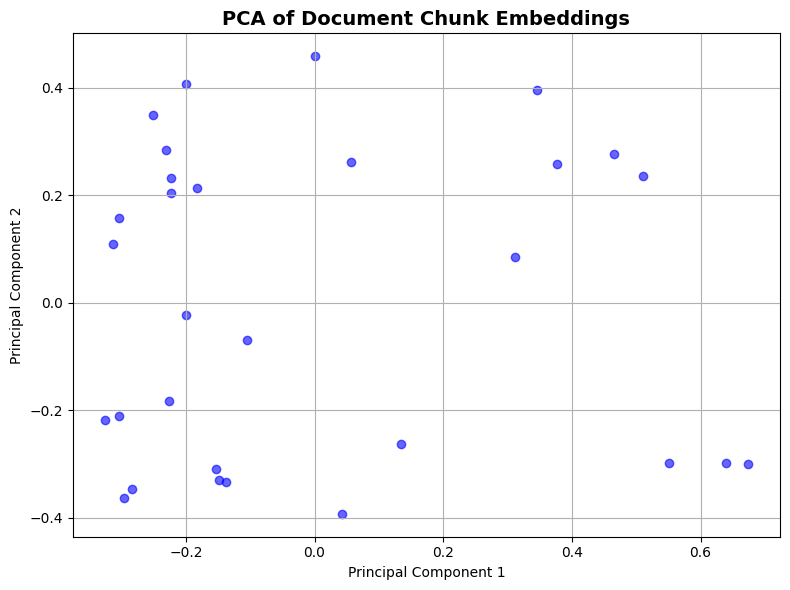

In [35]:
from sklearn.decomposition import PCA

sample_chunks = chunks[:30]
sample_texts = [chunk.page_content for chunk in sample_chunks]
vectors = embeddings.embed_documents(sample_texts)
vectors_array = np.array(vectors)

print(f"Embedding shape: {vectors_array.shape}")

pca = PCA(n_components=2)
coords = pca.fit_transform(vectors_array)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c='blue', alpha=0.6)
plt.title('PCA of Document Chunk Embeddings', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Load FAISS & Test Retrieval